In [3]:
import numpy as np
import scipy.io
import xarray as xr
import os
import pandas as pd
from datetime import datetime, date, time
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import gsw
import cmocean.cm as cmo

from data_loading import get_altimetry_data, get_2021_CTD_data

## Choosing the section

/Users/juliencollard/Nextcloud/Documents/Travail/Sorbonne/Cours/Code_MOCIS/FOET/FOET_Northern_Gyre/data_loading.py:70: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = xr.Dataset(
/Users/juliencollard/Nextcloud/Documents/Travail/Sorbonne/Cours/Code_MOCIS/FOET/FOET_Northern_Gyre/data_loading.py:70: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond

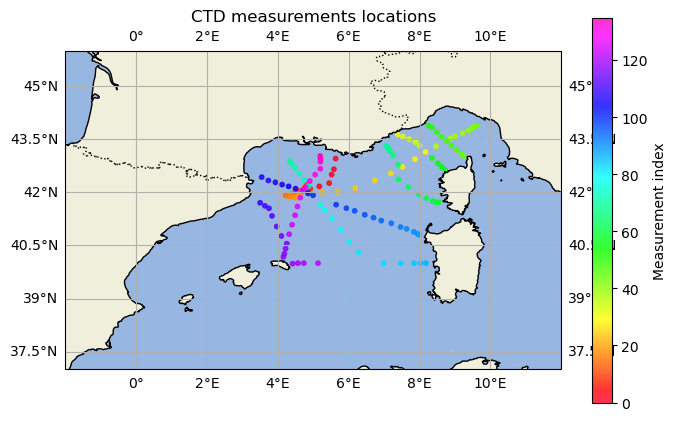

In [5]:
ds = get_2021_CTD_data()

# Map of measurements locations
fig, ax = plt.subplots(figsize=(8,5), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-2, 12, 37, 46])
ax.coastlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.OCEAN)
ax.gridlines(draw_labels=True)
sc = ax.scatter(ds.longitude, ds.latitude, s=10, c=ds.idx, cmap='gist_rainbow', alpha=0.8)
plt.colorbar(sc, ax=ax, label='Measurement index')
plt.title('CTD measurements locations')
plt.show()


/opt/anaconda3/lib/python3.12/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


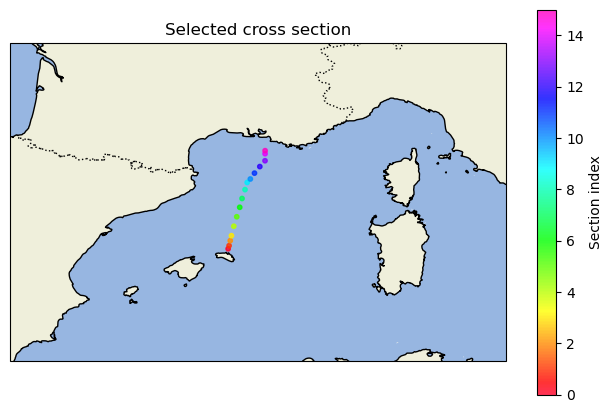

In [23]:
selected_idxs = list(range(115, ds.idx.max().values))
selected_idxs.remove(122)
selected_idxs.remove(121)
selected_idxs.remove(120)
selected_idxs.remove(119)

section_ds = ds.sel(idx=selected_idxs)
section_ds = section_ds.sortby('latitude')
section_ds['section_idx'] = np.arange(len(section_ds.latitude))



# Map of measurements locations
fig, ax = plt.subplots(figsize=(8,5), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-2, 12, 37, 46])
ax.coastlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.OCEAN)
sc = ax.scatter(section_ds.longitude, section_ds.latitude, s=10, c=section_ds.section_idx, alpha=0.8, cmap='gist_rainbow')
plt.colorbar(sc, ax=ax, label='Section index')
plt.title('Selected cross section')
plt.show()


## Profiles


In [24]:
section_ds['density'] = gsw.rho_t_exact(section_ds.salinity, section_ds.temperature, section_ds.pressure)
D = section_ds['density'].values
min_density = np.nanmin(D)
max_density = np.nanmax(D)

In [25]:
section_ds

<xarray.Dataset>
Dimensions:      (idx: 16, depth: 2901, section_idx: 16)
Coordinates:
  * idx          (idx) int64 118 117 116 115 123 124 ... 129 130 131 132 133 134
  * depth        (depth) float64 -0.0 -0.9921 -1.984 ... -2.856e+03 -2.857e+03
    latitude     (idx) float64 40.18 40.27 40.41 40.55 ... 42.66 42.86 42.95
    longitude    (idx) float64 4.157 4.184 4.217 4.25 ... 5.051 5.198 5.2 5.2
    time         (idx) datetime64[ns] 2021-06-29 2021-06-29 ... 2021-07-02
    file_name    (idx) object 'moose2021_ge_leg2_050.cnv' ... 'moose2021_ge_l...
  * section_idx  (section_idx) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
Data variables:
    temperature  (idx, depth) float64 nan 24.17 24.18 24.19 ... nan nan nan nan
    salinity     (idx, depth) float64 nan 36.98 36.98 36.98 ... nan nan nan nan
    pressure     (idx, depth) float64 0.0 1.0 2.0 ... 2.899e+03 2.9e+03
    density      (idx, depth) float64 nan 1.025e+03 1.025e+03 ... nan nan nan


### Temperature profile

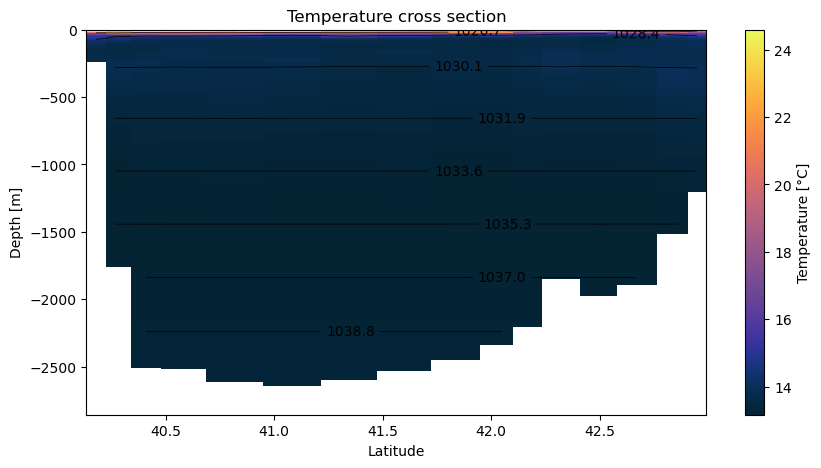

In [26]:
# T cross section plot
X = section_ds['temperature'].values

fig, ax = plt.subplots(figsize=(10,5))
cmesh = ax.pcolormesh(
    section_ds.latitude, 
    section_ds.depth, 
    X.T, 
    cmap=cmo.thermal,
)
plt.colorbar(cmesh, ax=ax, label='Temperature [°C]')
cont = ax.contour(
    section_ds.latitude, 
    section_ds.depth, 
    D.T, 
    colors='black', 
    linewidths=0.5, 
    levels=np.linspace(min_density, max_density, 10)
)
plt.clabel(cont, fmt='%1.1f')
plt.xlabel('Latitude')
plt.ylabel('Depth [m]')
plt.title('Temperature cross section')
plt.show()

### Salinity profile

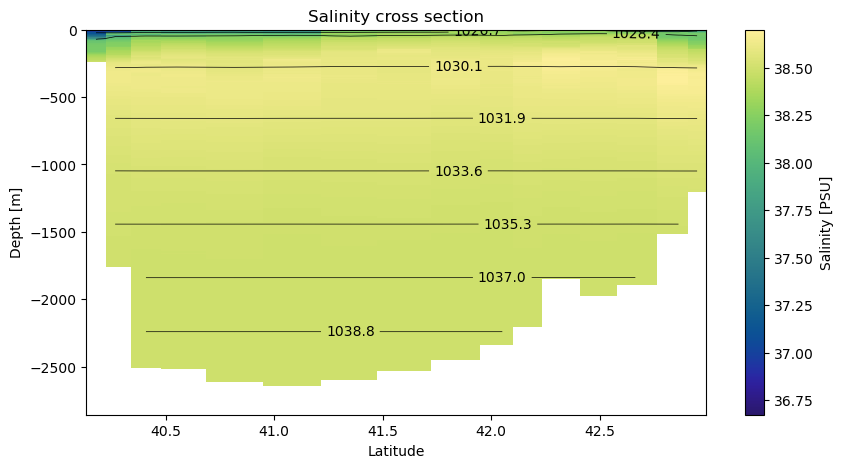

In [27]:
# S cross section plot
S = section_ds['salinity'].values

fig, ax = plt.subplots(figsize=(10,5))
cmesh = ax.pcolormesh(
    section_ds.latitude, 
    section_ds.depth, 
    S.T, 
    cmap=cmo.haline,
)
plt.colorbar(cmesh, ax=ax, label='Salinity [PSU]')
cont = ax.contour(
    section_ds.latitude, 
    section_ds.depth, 
    D.T, 
    colors='black', 
    linewidths=0.5, 
    levels=np.linspace(min_density, max_density, 10)
)
plt.clabel(cont, fmt='%1.1f')
plt.xlabel('Latitude')
plt.ylabel('Depth [m]')
plt.title('Salinity cross section')
plt.show()

### Density profile

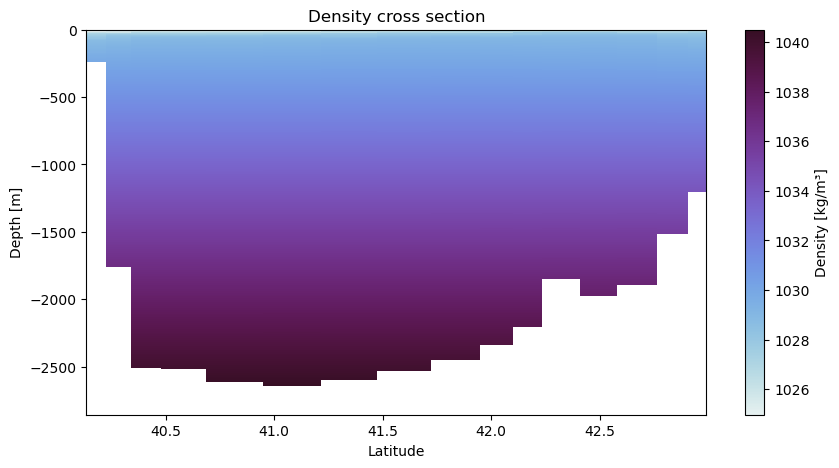

In [28]:
fig, ax = plt.subplots(figsize=(10,5))
cmesh = ax.pcolormesh(
    section_ds.latitude, 
    section_ds.depth, 
    D.T, 
    cmap=cmo.dense,
)
plt.colorbar(cmesh, ax=ax, label='Density [kg/m³]')
plt.xlabel('Latitude')
plt.ylabel('Depth [m]')
plt.title('Density cross section')
plt.show()

### Zoom on surface layers

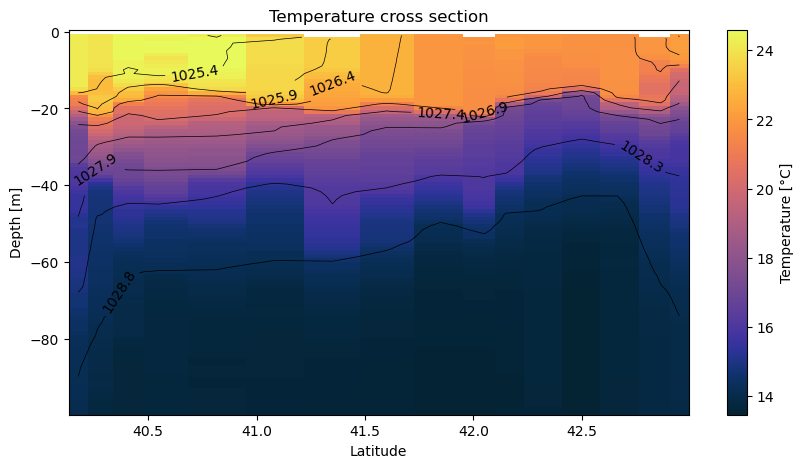

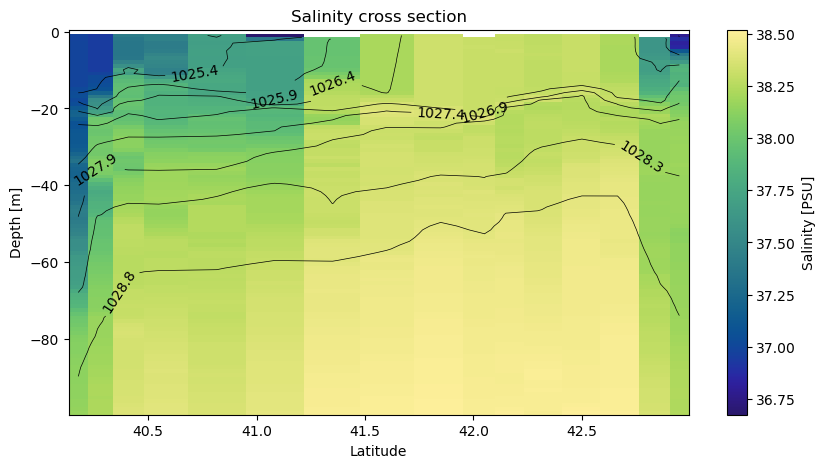

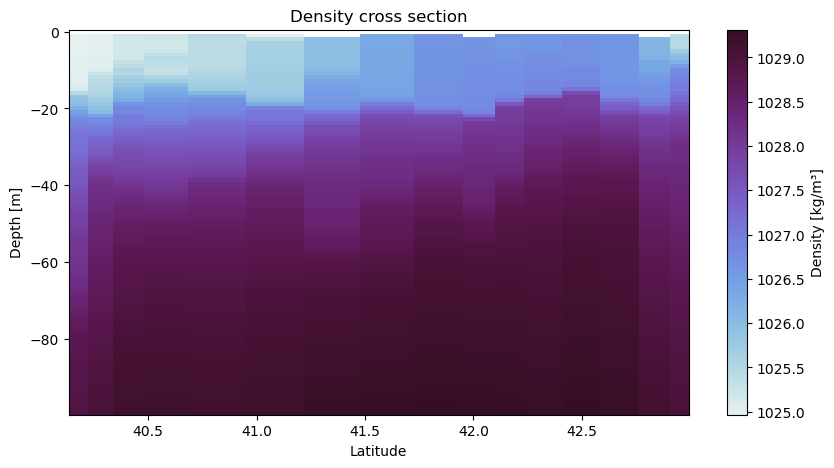

In [30]:
max_depth = 100

serface_section_ds = section_ds.where(-section_ds.depth <= max_depth, drop=True)

D = serface_section_ds['density'].values
min_density = np.nanmin(D)
max_density = np.nanmax(D)

# T cross section plot
X = serface_section_ds['temperature'].values

fig, ax = plt.subplots(figsize=(10,5))
cmesh = ax.pcolormesh(
    serface_section_ds.latitude, 
    serface_section_ds.depth, 
    X.T, 
    cmap=cmo.thermal,
)
plt.colorbar(cmesh, ax=ax, label='Temperature [°C]')
cont = ax.contour(
    serface_section_ds.latitude, 
    serface_section_ds.depth, 
    D.T, 
    colors='black', 
    linewidths=0.5, 
    levels=np.linspace(min_density, max_density, 10)
)
plt.clabel(cont, fmt='%1.1f')
plt.xlabel('Latitude')
plt.ylabel('Depth [m]')
plt.title('Temperature cross section')
plt.show()

# S cross section plot
S = serface_section_ds['salinity'].values

fig, ax = plt.subplots(figsize=(10,5))
cmesh = ax.pcolormesh(
    serface_section_ds.latitude, 
    serface_section_ds.depth, 
    S.T, 
    cmap=cmo.haline,
)
plt.colorbar(cmesh, ax=ax, label='Salinity [PSU]')
cont = ax.contour(
    serface_section_ds.latitude, 
    serface_section_ds.depth, 
    D.T, 
    colors='black', 
    linewidths=0.5, 
    levels=np.linspace(min_density, max_density, 10)
)
plt.clabel(cont, fmt='%1.1f')
plt.xlabel('Latitude')
plt.ylabel('Depth [m]')
plt.title('Salinity cross section')
plt.show()

# D cross section plot

fig, ax = plt.subplots(figsize=(10,5))
cmesh = ax.pcolormesh(
    serface_section_ds.latitude, 
    serface_section_ds.depth, 
    D.T, 
    cmap=cmo.dense,
)
plt.colorbar(cmesh, ax=ax, label='Density [kg/m³]')
plt.xlabel('Latitude')
plt.ylabel('Depth [m]')
plt.title('Density cross section')
plt.show()


In [32]:
ds

<xarray.Dataset>
Dimensions:      (idx: 136, depth: 2901)
Coordinates:
  * idx          (idx) int64 0 1 2 3 4 5 6 7 ... 128 129 130 131 132 133 134 135
  * depth        (depth) float64 -0.0 -0.9921 -1.984 ... -2.856e+03 -2.857e+03
    latitude     (idx) float64 42.95 42.65 42.5 42.26 ... 42.86 42.95 43.03
    longitude    (idx) float64 5.629 5.582 5.517 5.448 ... 5.198 5.2 5.2 5.194
    time         (idx) datetime64[ns] 2021-06-09 2021-06-09 ... 2021-07-02
    file_name    (idx) object 'moose2021_ge_leg1_001.cnv' ... 'moose2021_ge_l...
Data variables:
    temperature  (idx, depth) float64 nan nan 19.99 20.11 ... nan nan nan nan
    salinity     (idx, depth) float64 nan nan 37.97 37.97 ... nan nan nan nan
    pressure     (idx, depth) float64 0.0 1.0 2.0 ... 2.899e+03 2.9e+03

/opt/anaconda3/lib/python3.12/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


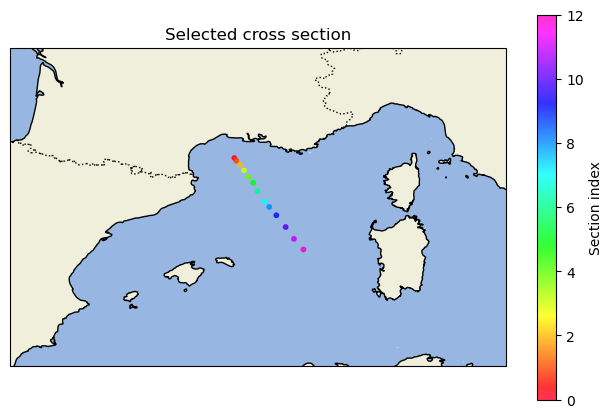

In [35]:
selected_idxs = list(range(69, 82))

section_ds = ds.sel(idx=selected_idxs)

# Ordering by increasing latitude
#section_ds = section_ds.sortby('lat')
section_ds['section_idx'] = np.arange(len(section_ds.idx))

# Map of measurements locations
fig, ax = plt.subplots(figsize=(8,5), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-2, 12, 37, 46])
ax.coastlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.OCEAN)
sc = ax.scatter(section_ds.longitude, section_ds.latitude, s=10, c=section_ds.section_idx, alpha=0.8, cmap='gist_rainbow')
plt.colorbar(sc, ax=ax, label='Section index')
plt.title('Selected cross section')
plt.show()


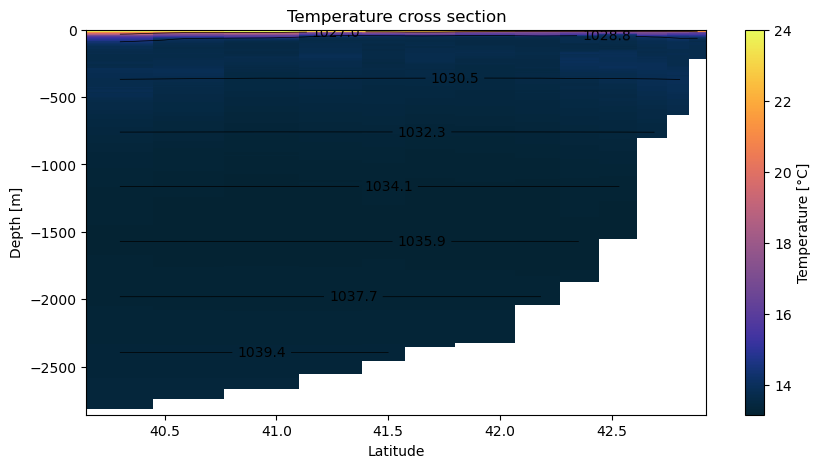

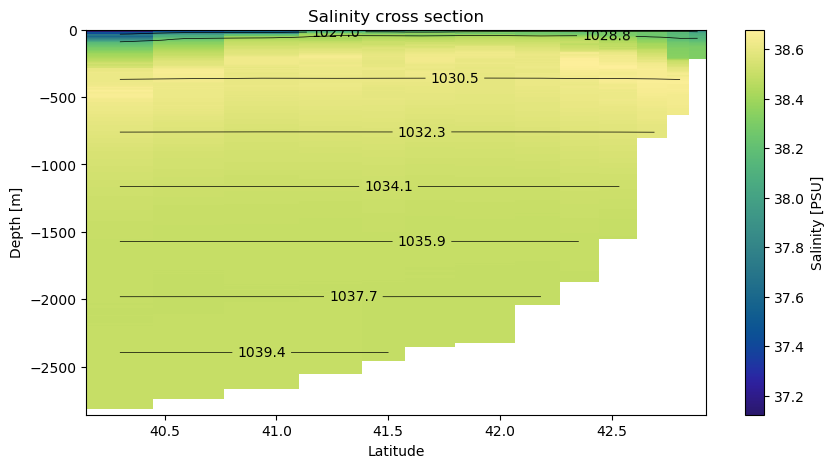

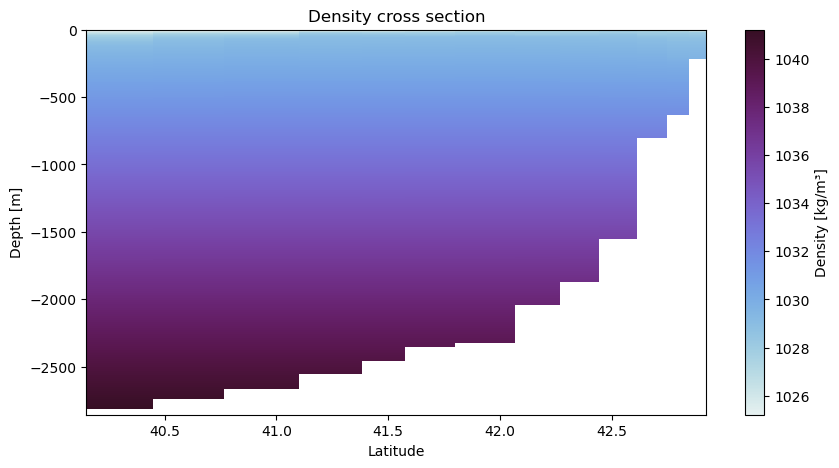

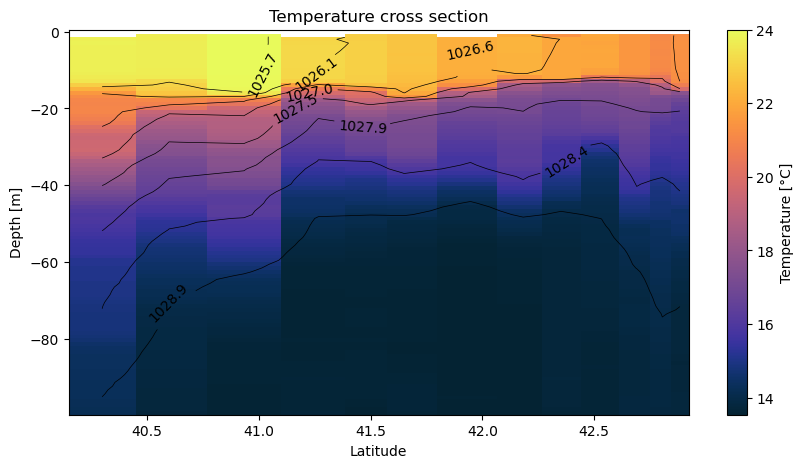

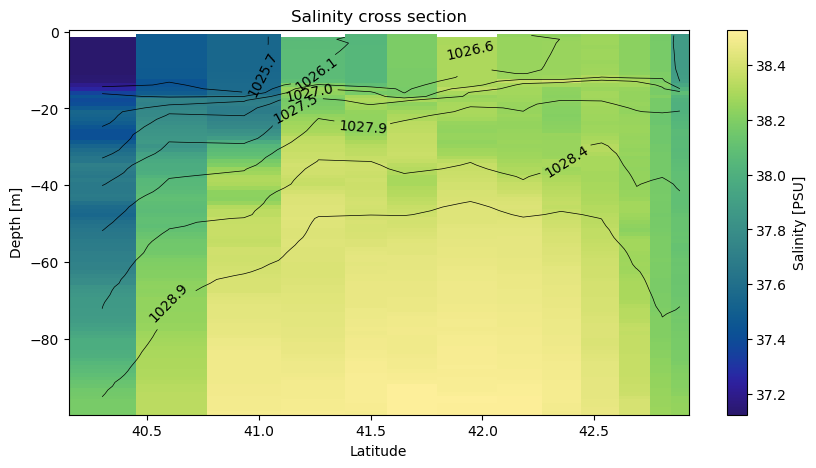

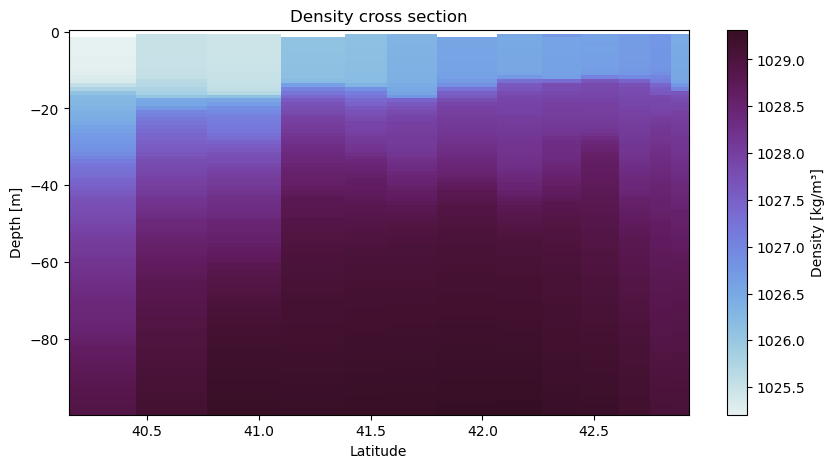

In [36]:
section_ds['density'] = gsw.rho_t_exact(section_ds.salinity, section_ds.temperature, section_ds.pressure)
D = section_ds['density'].values
min_density = np.nanmin(D)
max_density = np.nanmax(D)

# T cross section plot
X = section_ds['temperature'].values

fig, ax = plt.subplots(figsize=(10,5))
cmesh = ax.pcolormesh(
    section_ds.latitude, 
    section_ds.depth, 
    X.T, 
    cmap=cmo.thermal,
)
plt.colorbar(cmesh, ax=ax, label='Temperature [°C]')
cont = ax.contour(
    section_ds.latitude, 
    section_ds.depth, 
    D.T, 
    colors='black', 
    linewidths=0.5, 
    levels=np.linspace(min_density, max_density, 10)
)
plt.clabel(cont, fmt='%1.1f')
plt.xlabel('Latitude')
plt.ylabel('Depth [m]')
plt.title('Temperature cross section')
plt.show()

# S cross section plot
S = section_ds['salinity'].values

fig, ax = plt.subplots(figsize=(10,5))
cmesh = ax.pcolormesh(
    section_ds.latitude, 
    section_ds.depth, 
    S.T, 
    cmap=cmo.haline,
)
plt.colorbar(cmesh, ax=ax, label='Salinity [PSU]')
cont = ax.contour(
    section_ds.latitude, 
    section_ds.depth, 
    D.T, 
    colors='black', 
    linewidths=0.5, 
    levels=np.linspace(min_density, max_density, 10)
)
plt.clabel(cont, fmt='%1.1f')
plt.xlabel('Latitude')
plt.ylabel('Depth [m]')
plt.title('Salinity cross section')
plt.show()

fig, ax = plt.subplots(figsize=(10,5))
cmesh = ax.pcolormesh(
    section_ds.latitude, 
    section_ds.depth, 
    D.T, 
    cmap=cmo.dense,
)
plt.colorbar(cmesh, ax=ax, label='Density [kg/m³]')
plt.xlabel('Latitude')
plt.ylabel('Depth [m]')
plt.title('Density cross section')
plt.show()

max_depth = 100

serface_section_ds = section_ds.where(-section_ds.depth <= max_depth, drop=True)

D = serface_section_ds['density'].values
min_density = np.nanmin(D)
max_density = np.nanmax(D)

# T cross section plot
X = serface_section_ds['temperature'].values

fig, ax = plt.subplots(figsize=(10,5))
cmesh = ax.pcolormesh(
    serface_section_ds.latitude, 
    serface_section_ds.depth, 
    X.T, 
    cmap=cmo.thermal,
)
plt.colorbar(cmesh, ax=ax, label='Temperature [°C]')
cont = ax.contour(
    serface_section_ds.latitude, 
    serface_section_ds.depth, 
    D.T, 
    colors='black', 
    linewidths=0.5, 
    levels=np.linspace(min_density, max_density, 10)
)
plt.clabel(cont, fmt='%1.1f')
plt.xlabel('Latitude')
plt.ylabel('Depth [m]')
plt.title('Temperature cross section')
plt.show()

# S cross section plot
S = serface_section_ds['salinity'].values

fig, ax = plt.subplots(figsize=(10,5))
cmesh = ax.pcolormesh(
    serface_section_ds.latitude, 
    serface_section_ds.depth, 
    S.T, 
    cmap=cmo.haline,
)
plt.colorbar(cmesh, ax=ax, label='Salinity [PSU]')
cont = ax.contour(
    serface_section_ds.latitude, 
    serface_section_ds.depth, 
    D.T, 
    colors='black', 
    linewidths=0.5, 
    levels=np.linspace(min_density, max_density, 10)
)
plt.clabel(cont, fmt='%1.1f')
plt.xlabel('Latitude')
plt.ylabel('Depth [m]')
plt.title('Salinity cross section')
plt.show()

# D cross section plot

fig, ax = plt.subplots(figsize=(10,5))
cmesh = ax.pcolormesh(
    serface_section_ds.latitude, 
    serface_section_ds.depth, 
    D.T, 
    cmap=cmo.dense,
)
plt.colorbar(cmesh, ax=ax, label='Density [kg/m³]')
plt.xlabel('Latitude')
plt.ylabel('Depth [m]')
plt.title('Density cross section')
plt.show()
